This notebook implements the Transformer architecture from scratch using PyTorch, following the original "Attention Is All You Need" paper by Vaswani et al. The implementation avoids using high-level APIs (like `torch.nn.Transformer`) to give a deeper understanding of the model’s internal mechanics.

## Objectives
- Understand the architecture of the Transformer.
- Build each component from scratch:
  - Positional Encoding
  - Scaled Dot-Product Attention
  - Multi-Head Attention
  - Feedforward Networks
  - Encoder and Decoder Layers
  - Full Transformer Model



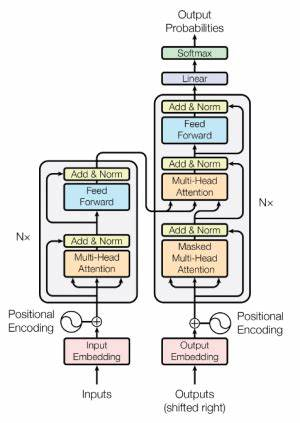

# Load dependencies

In [ ]:
import requests
import re
import numpy as np
import seaborn as sns

np.random.seed(22)

# 1. Data Preparation

## 1.1. Load the data

In [ ]:
# URL of the plain text file
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

In [ ]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it'


## 1.2. Tokenize the data

In [ ]:
class SimpleTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> -> Handling out-of-vocabulary words
    # - (BOS) -> Put in begenning of each document
    # - (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

  def __len__(self):
    return len(self.voc_str_int)

## 1.3. Data Loader

In [ ]:
class SimpleDataLoader:
  def __init__(self, token_ids, context_size=4, batch_size=1, stride=1):
    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):
    X, Y = [], []
    for i in range(0, len(token_ids) - self.context_size - 1, self.stride):
      x = token_ids[i : i + self.context_size]
      y = token_ids[i + 1 : i + self.context_size + 1]
      if len(y) == self.context_size:
        X.append(x)
        Y.append(y)
    return X, Y

  def __len__(self):
    return len(self.X) // self.batch_size

  def __getitem__(self, idx):
    start = idx * self.batch_size
    end = start + self.batch_size
    return self.X[start:end], self.Y[start:end]

## 1.4. Token Embeddings

In [ ]:
# Tokenizer
tokenizer = SimpleTokenizer(text)
token_ids = tokenizer.encode(text)

# Data Loader
context_size = 5
dataloader = SimpleDataLoader(token_ids, context_size, 8, 4)
x_batch, y_batch = dataloader[0]

print("X:", x_batch[0])
print("Y:", y_batch[0])

# Embedding Layer
vector_dimension = 100
vocabulary_size = len(tokenizer)
embedding_layer = np.random.randn(vocabulary_size, vector_dimension)

print(embedding_layer[x_batch[0]],"\n\n")  # Embedding vectors of the input for the fisrt sample (5 * 100)
print(embedding_layer[y_batch[0]]) # Embedding vectors of the output for the fisrt sample (5 * 100)

x_token_embedding = embedding_layer[x_batch]  # Embedding vectors of the input for the fisrt sample (5 * 100)
y_token_embedding = embedding_layer[y_batch] # Embedding vectors of the output for the fisrt sample (5 * 100)

X: [53, 44, 149, 1003, 57]
Y: [44, 149, 1003, 57, 38]
[[ 5.83516080e-01 -1.13817268e+00  6.54614139e-02 -1.32613475e+00
   8.54764728e-02  7.94476215e-01 -4.52588517e-01  1.77115453e+00
   1.77050706e-01 -1.38615084e+00  1.22386558e+00  8.77388373e-02
  -2.09382277e-01 -7.73519915e-01  6.31548213e-01  2.29914506e-01
   3.75536447e-01 -5.72843514e-01 -1.30863998e+00 -1.13860196e+00
  -9.03212455e-01  1.39022425e-01  5.78167352e-01  6.59988419e-01
  -6.45553907e-01 -5.77965803e-01  1.73408928e+00  5.06543518e-01
   7.48484844e-01  1.31246518e+00  7.84547485e-01  6.64289586e-01
   1.18374530e-02 -5.91872400e-01 -2.50017001e-02  1.48753749e+00
   6.29474037e-01  5.51251968e-01 -1.30461013e+00 -5.93483433e-02
  -9.35458505e-01  5.66834483e-01 -1.26784561e+00  8.53256404e-01
  -1.69070090e-01 -1.37315738e+00  6.00671174e-02 -1.08937808e+00
   1.29986740e-01  2.99385441e-01  2.11561152e+00 -6.20561632e-01
  -5.56200449e-01  7.51063892e-02  2.76466932e-01  1.99136335e+00
  -1.20459036e+00 -3.2

## 1.5. Positional values

In [ ]:
# Create position values
position_values = np.random.random((context_size, vector_dimension))

# Create Postion encoded values
position_encoded_values = x_token_embedding + position_values

print(position_encoded_values[0])

[[ 8.44565776e-01 -2.33155154e-01  1.59885050e-01 -8.42528874e-01
   9.79520981e-01  1.52167526e+00 -3.69386160e-01  2.42886631e+00
   4.30586576e-01 -1.23816565e+00  1.81228581e+00  5.27164995e-01
   7.57561907e-01 -4.27039836e-01  1.34613021e+00  1.00075662e+00
   1.01404271e+00 -3.43158449e-01 -1.14166754e+00 -4.64238628e-01
  -5.40061151e-01  9.00272090e-01  9.70827083e-01  1.37975067e+00
   4.14267585e-02 -4.85347739e-01  1.88540827e+00  6.69474497e-01
   9.17089801e-01  1.37893110e+00  1.48256287e+00  1.37622874e+00
   8.33700649e-01 -2.00227638e-01  4.65760547e-01  1.93449636e+00
   8.21726474e-01  1.52705660e+00 -1.23384517e+00  7.38605983e-02
  -5.03424083e-01  1.30596239e+00 -6.11205698e-01  8.57145429e-01
  -3.04954854e-02 -6.95262494e-01  3.10179871e-01 -3.10989994e-01
   3.90732437e-01  6.87919700e-01  2.32745451e+00  3.68549308e-01
  -3.17965163e-01  1.28387449e-01  5.04099384e-01  2.21635750e+00
  -4.29276331e-01 -2.16625868e-01  2.31429351e+00  4.78099970e-01
  -2.14230

# 2.1. Simple Self attention (without trainable weights)

[[10.57340848  2.60020027  3.86532849  3.03665519  2.29906919]
 [ 2.60020027 12.23464091  2.4932864   2.17725055  1.06039354]
 [ 3.86532849  2.4932864  14.99708227  3.0604283   3.45550102]
 [ 3.03665519  2.17725055  3.0604283  13.40800101  1.75868706]
 [ 2.29906919  1.06039354  3.45550102  1.75868706 14.1800262 ]]
[[9.97651847e-01 6.54239760e-05 1.46394826e-05 3.13144411e-05
  6.92071153e-06]
 [3.43762645e-04 9.99818897e-01 3.71240558e-06 1.32589756e-05
  2.00539879e-06]
 [1.21813912e-03 5.87901859e-05 9.99965385e-01 3.20678020e-05
  2.19979754e-05]
 [5.31873863e-04 4.28600040e-05 6.54578915e-06 9.99914634e-01
  4.03149171e-06]
 [2.54377747e-04 1.40283751e-05 9.71717262e-06 8.72429129e-06
  9.99965044e-01]]
[[ 8.42606070e-01 -2.32594114e-01  1.59526847e-01 -8.40386545e-01
   9.77408187e-01  1.51824334e+00 -3.68506300e-01  2.42321968e+00
   4.29688173e-01 -1.23519800e+00  1.80797001e+00  5.25900046e-01
   7.55846417e-01 -4.26052715e-01  1.34300158e+00  9.98421427e-01
   1.01174956e+00 -

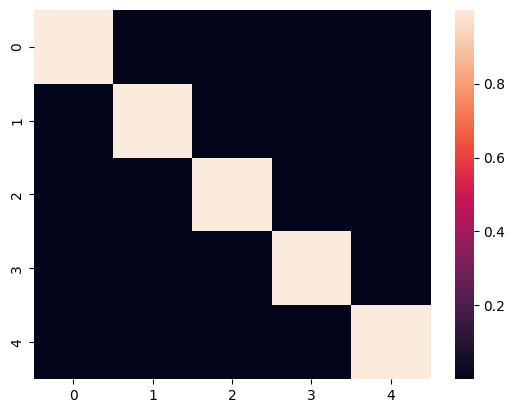

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

attention_values = np.dot(position_encoded_values[0], position_encoded_values[0].T) # Queries * Keys
scaled_attention_values = attention_values / np.sqrt(vector_dimension) # Scaling
print(scaled_attention_values)

props = softmax(scaled_attention_values) # Softmax activation funtion
print(props)
sns.heatmap(props)

x_batch_vectors = np.dot(props, position_encoded_values[0]) # Attention_scores * Values
print(x_batch_vectors)

# 2.1. Self attention mechanism with query, key, and value matrices

In [ ]:
class self_attention:
  def __init__(self, vector_dimention, context_size):
    self.vector_dimention = vector_dimention
    self.context_size = context_size
    self.query_matrix = np.random.randn(vector_dimention, vector_dimention)
    self.key_matrix = np.random.randn(vector_dimention, vector_dimention)
    self.value_matrix = np.random.randn(vector_dimention, vector_dimention)

  def __softmax(self, x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

  def __call__(self, x):
    queries = np.dot(x, self.query_matrix) # (context_size * vec_dim) . (vec_dim * vec_dim) = (context_size * vec_dim)
    keys = np.dot(x, self.key_matrix)      # (context_size * vec_dim) . (vec_dim * vec_dim) = (context_size * vec_dim)
    values = np.dot(x, self.value_matrix)  # (context_size * vec_dim) . (vec_dim * vec_dim) = (context_size * vec_dim)

    attention_values = np.dot(queries, keys.T) # word similarities (context_size * vec_dim) . (context_size * vec_dim).T = (context_size * context_size)
    scaled_attention_values = attention_values / np.sqrt(self.vector_dimention) # Scale to achieve scalability (vec_dim * vec_dim)
    props = self.__softmax(scaled_attention_values) # probabilities (vec_dim * vec_dim)
    x_vectors = np.dot(props, values) # (context_size * context_size) . (context_size * vec_dim) = (context_size * vec_dim)

    return x_vectors

# 2.1. Multi-Head Attention

In [ ]:
class multihead_attention:
  def __init__(self):
    pass